# Handling distractor interference in mixed and fixed search 
### A. A. Hanne, J. Tünnermann & A. Schubö

Fitting Bayesian Generalized Linear Mixed Models using the Python package Bambi.
Citation: Capretto, T., Piho, C., Kumar, R., Westfall, J., Yarkoni, T., & Martin, O. A. (2022). Bambi: A Simple Interface for Fitting Bayesian Linear Models in Python. Journal of Statistical Software, 103(15). https://doi.org/10.18637/jss.v103.i15

GitHub: https://bambinos.github.io/bambi/

The analyses were performed with a Bambi version installed from 
https://github.com/GStechschulte/bambi.git@8fa47aa, Python version 3.9.18 and PyMC version 5.8.2.

Due to the stochastic nature of MCMC sampling, the results depicted in this notebook might differ slightly numerically from the values reported in the paper.

This notebook can sample the traces or you can load them from disk (see README.md) and copy them in a traces/ subfolder.

## Task Performance

### 1) Define and run model

In [15]:
import pandas as pd
import arviz as az
import bambi as bmb
import pymc as pm
import cloudpickle
import warnings
from os import path
warnings.filterwarnings("ignore")

seed=12345
tune = 5000
draws = 20000
name = 'TaskPerformance_trace'

fn = 'traces/%s.nc'%name

# Avoid that the user sampels a trace which cannot be stored due to existing file:
if path.exists(fn):
    raise Exception("%s already exisits. Rename new trace above or rename/delete old trace"%fn)

data = pd.read_csv('data/Dataset_TaskPerformance.csv', sep=';', decimal=',')

model = bmb.Model(
    '''p(correct, count) ~ 
       task*session*epoch + (1|participant) 
    ''',
    data, family='binomial', categorical=["session", "task", "participant"])

display(model)
model.build()

idata = az.InferenceData()

print('Sampling default prior predictive')
pp = model.prior_predictive(3000)
idata.add_groups({'default_prior': pp.prior, 'default_prior_predictive': pp.prior_predictive})

# Customize priors
priors = {
"Intercept": bmb.Prior("Normal", mu=0, sigma=0.5),
"task": bmb.Prior("Normal", mu=[0, 0], sigma=[0.5, 0.5]),
"session": bmb.Prior("Normal", mu=0, sigma=0.5),
"task:session": bmb.Prior("Normal", mu=[0, 0], sigma=[0.3, 0.3]),
"epoch": bmb.Prior("Normal", mu=0, sigma=0.5),
"task:epoch": bmb.Prior("Normal", mu=[0,0], sigma=[0.1, 0.1]),
"session:epoch": bmb.Prior("Normal", mu=0, sigma=0.1),
"task:session:epoch": bmb.Prior("Normal", mu=[0,0], sigma=[0.1, 0.1]),
    
"1|participant": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfCauchy", beta=0.01))}

model.set_priors(priors = priors)
model.build()

print('Sampling custom prior predictive')
idata.extend(model.prior_predictive(3000))

print('Sampling posterior')
idata.extend(
    model.fit(tune=tune, draws=draws, random_seed=seed, init='adapt_diag', target_accept=0.99, idata_kwargs={'log_likelihood':True})
)

print('Saving trace to ' + fn)

idata.to_netcdf(fn)

Exception: traces/TaskPerformance_trace.nc already exisits. Rename new trace above or rename/delete old trace

### 2) Plot prior predictive distributions

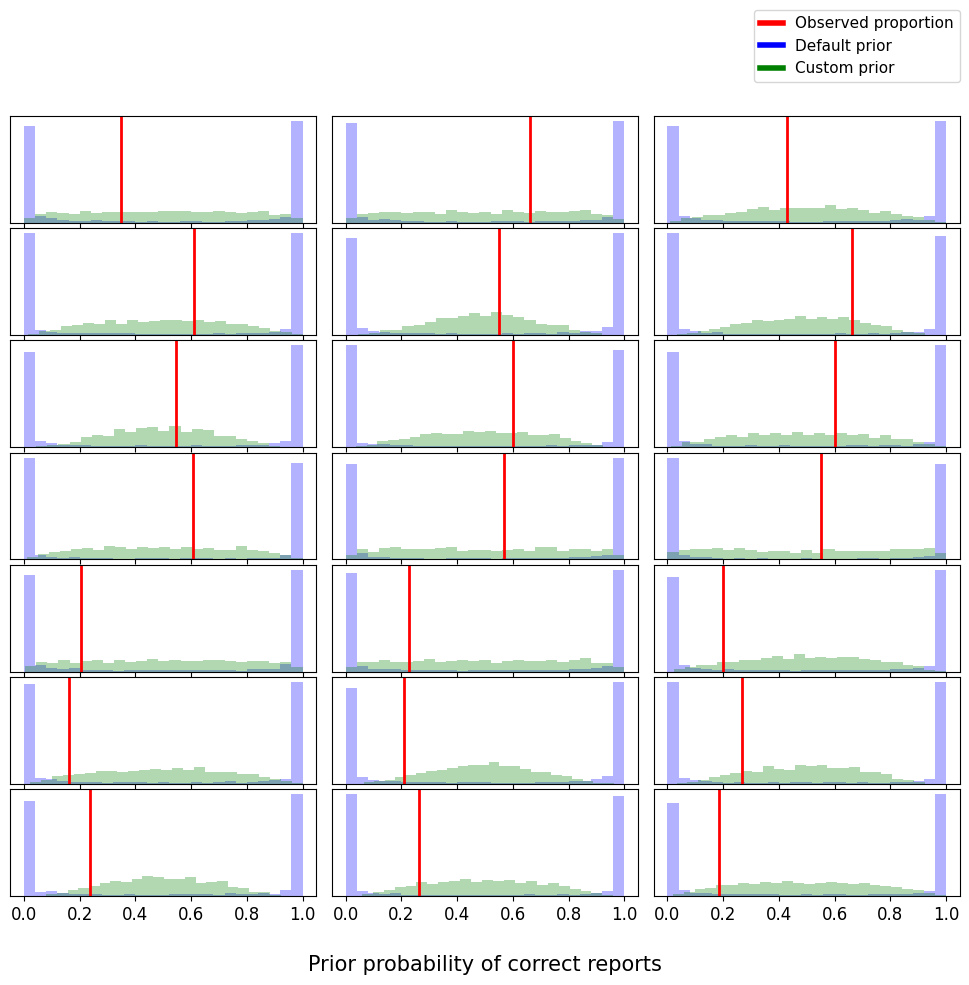

In [1]:
import arviz as az 
from plots import plot_prior_predictive
import pandas as pd
import pymc as pm
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('data/Dataset_TaskPerformance.csv', sep=';', decimal=',') 
idata = az.from_netcdf('traces/TaskPerformance_trace.nc')                                   
default_prior = az.extract_dataset(idata, group='default_prior_predictive')['p(correct, count)']
custom_prior = az.extract_dataset(idata, group='prior_predictive')['p(correct, count)']

axs = plot_prior_predictive(data, default_prior)
axs = plot_prior_predictive(data, custom_prior, axes=axs, draw_data=False, color='green')

### 3) Traceplots

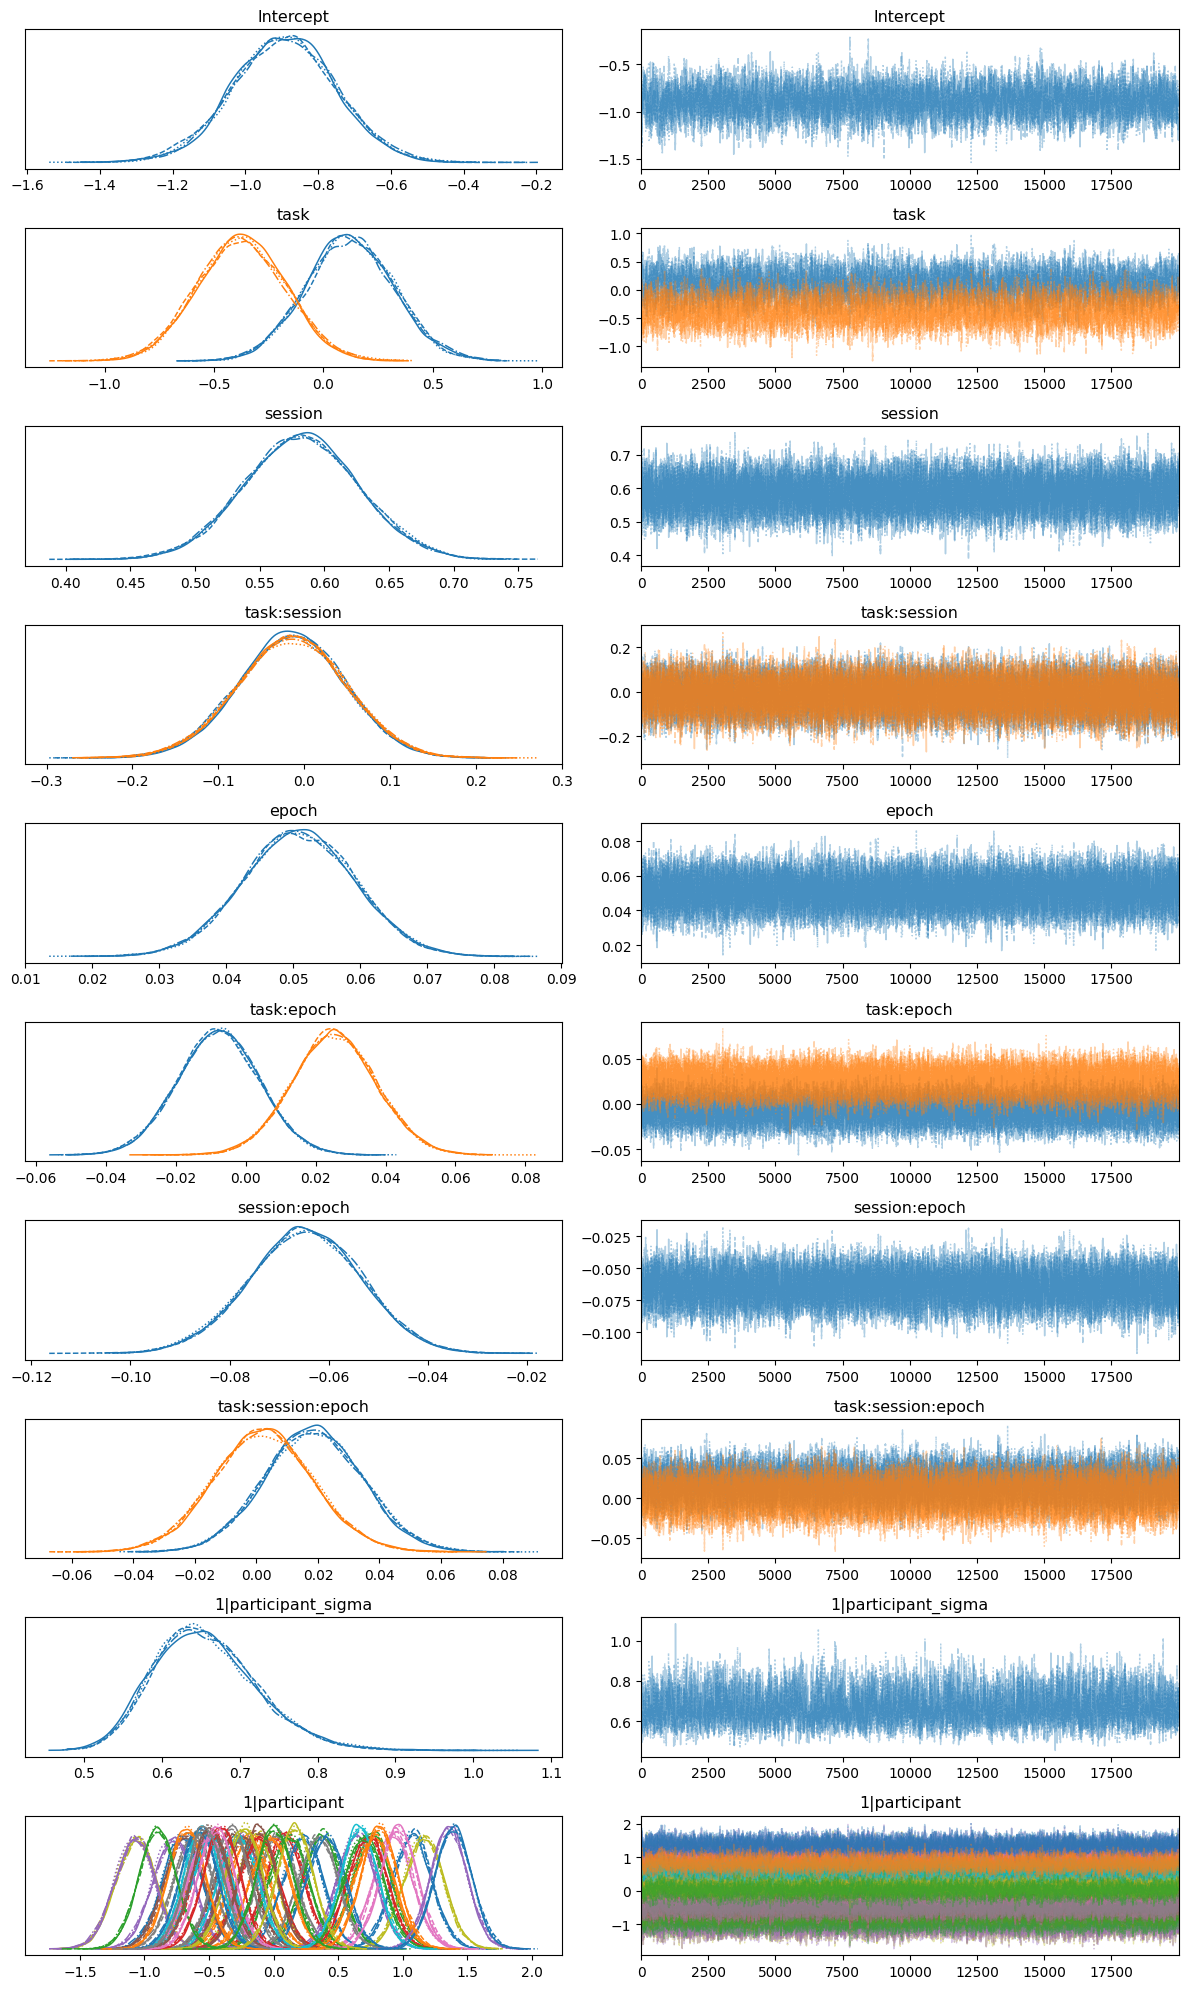

In [4]:
import arviz as az
from matplotlib.pylab import plt
import warnings
warnings.filterwarnings("ignore")

idata = az.from_netcdf('traces/TaskPerformance_trace.nc') 
az.plot_trace(idata, compact=True)
plt.tight_layout()

### 4) Get summary

In [3]:
import arviz as az
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
az.rcParams['stats.hdi_prob'] = 0.95

pd.set_option('display.max_rows', None)
idata = az.from_netcdf('traces/TaskPerformance_trace.nc') 
az.summary(idata)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.893,0.142,-1.169,-0.612,0.002,0.002,3663.0,6401.0,1.0
task[gray],0.121,0.201,-0.276,0.513,0.004,0.003,3243.0,5145.0,1.0
task[mixed],-0.374,0.203,-0.768,0.019,0.003,0.002,3539.0,6599.0,1.0
session[2],0.583,0.044,0.497,0.670,0.000,0.000,8087.0,14939.0,1.0
"task:session[gray, 2]",-0.015,0.062,-0.138,0.106,0.001,0.000,8063.0,16392.0,1.0
"task:session[mixed, 2]",-0.015,0.064,-0.140,0.110,0.001,0.000,9213.0,15879.0,1.0
epoch,0.051,0.008,0.034,0.067,0.000,0.000,9053.0,18409.0,1.0
task:epoch[gray],-0.008,0.012,-0.031,0.015,0.000,0.000,9135.0,18616.0,1.0
task:epoch[mixed],0.025,0.012,0.002,0.049,0.000,0.000,10034.0,18780.0,1.0
session:epoch[2],-0.065,0.011,-0.087,-0.043,0.000,0.000,7801.0,14125.0,1.0


### 5) Compute predictions and comparisons

In [8]:
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import bambi as bmb
from bambi.interpret.helpers import data_grid, select_draws
import warnings
bmb.config["INTERPRET_VERBOSE"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

data = pd.read_csv('data/Dataset_TaskPerformance.csv', sep=';', decimal=',')
data['report frequency target (%)'] = data['correct'] / data['count']

idata = az.from_netcdf('traces/TaskPerformance_trace.nc')

model = bmb.Model(
    '''p(correct, count) ~ 
       task*session*epoch + (1|participant) 
    ''',
    data, family='binomial', categorical=["session", "task", "participant"])

# Create data_grid
tasks = ["color", "gray", "mixed"]
sessions = [1, 2]
participants_mixed = np.arange(1, 19)
participants_gray = np.arange(19, 36)
participants_color = np.arange(36, 54 )

variables = {"epoch": np.arange(1, 7)}

data_dict = {}
idata_dict = {}

for task in tasks:
    for session in sessions:
        if task == "mixed":
            participants = participants_mixed
        elif task == "gray":
            participants = participants_gray
        else:
            participants = participants_color
            
        conditional = {"participant": participants, "session": np.array([session]), "task": np.array([task])}
        key = f"{task}_session{session}_data"
        data_dict[key] = data_grid(model, conditional, variables)
        idata_dict[key] = model.predict(idata, data=data_dict[key], inplace=False)
        
        
results_list = []
hdi_epoch1_list = []
hdi_epoch2_list = []
hdi_epoch3_list = []
hdi_epoch4_list = []
hdi_epoch5_list = []
hdi_epoch6_list = []
within_comparisons_list = []
hdi_within_comparisons_list = []
between_comparisons_list = []
hdi_between_comparisons_list = []

def calculate_stats(idata_dict, data_dict, session, task):
    key = f"{task}_session{session}_data"
    draws_epoch1 = select_draws(idata_dict[key], data_dict[key], {"epoch": 1}, "p(correct, count)_mean")
    draws_epoch2 = select_draws(idata_dict[key], data_dict[key], {"epoch": 2}, "p(correct, count)_mean")
    draws_epoch3 = select_draws(idata_dict[key], data_dict[key], {"epoch": 3}, "p(correct, count)_mean")
    draws_epoch4 = select_draws(idata_dict[key], data_dict[key], {"epoch": 4}, "p(correct, count)_mean")
    draws_epoch5 = select_draws(idata_dict[key], data_dict[key], {"epoch": 5}, "p(correct, count)_mean")
    draws_epoch6 = select_draws(idata_dict[key], data_dict[key], {"epoch": 6}, "p(correct, count)_mean")

    draws_epoch1_mean = draws_epoch1.mean("p(correct, count)_obs").values
    draws_epoch2_mean = draws_epoch2.mean("p(correct, count)_obs").values
    draws_epoch3_mean = draws_epoch3.mean("p(correct, count)_obs").values
    draws_epoch4_mean = draws_epoch4.mean("p(correct, count)_obs").values
    draws_epoch5_mean = draws_epoch5.mean("p(correct, count)_obs").values
    draws_epoch6_mean = draws_epoch6.mean("p(correct, count)_obs").values
       
    results_list.append({"session": session, "epoch": 1, "task": task, "estimate": np.mean(draws_epoch1_mean)})
    results_list.append({"session": session, "epoch": 2, "task": task, "estimate": np.mean(draws_epoch2_mean)})
    results_list.append({"session": session, "epoch": 3, "task": task, "estimate": np.mean(draws_epoch3_mean)})
    results_list.append({"session": session, "epoch": 4, "task": task, "estimate": np.mean(draws_epoch4_mean)})
    results_list.append({"session": session, "epoch": 5, "task": task, "estimate": np.mean(draws_epoch5_mean)})
    results_list.append({"session": session, "epoch": 6, "task": task, "estimate": np.mean(draws_epoch6_mean)})
    
    # HDIs
    hdi_epoch1 = az.hdi(draws_epoch1.mean("p(correct, count)_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_epoch1_df = hdi_epoch1.to_dataframe(dim_order=None)
    hdi_epoch1_list.append(hdi_epoch1_df)
    
    hdi_epoch2 = az.hdi(draws_epoch2.mean("p(correct, count)_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_epoch2_df = hdi_epoch2.to_dataframe(dim_order=None)
    hdi_epoch2_list.append(hdi_epoch2_df)
    
    hdi_epoch3 = az.hdi(draws_epoch3.mean("p(correct, count)_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_epoch3_df = hdi_epoch3.to_dataframe(dim_order=None)
    hdi_epoch3_list.append(hdi_epoch3_df)
    
    hdi_epoch4 = az.hdi(draws_epoch4.mean("p(correct, count)_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_epoch4_df = hdi_epoch4.to_dataframe(dim_order=None)
    hdi_epoch4_list.append(hdi_epoch4_df)
    
    hdi_epoch5 = az.hdi(draws_epoch5.mean("p(correct, count)_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_epoch5_df = hdi_epoch5.to_dataframe(dim_order=None)
    hdi_epoch5_list.append(hdi_epoch5_df)
    
    hdi_epoch6 = az.hdi(draws_epoch6.mean("p(correct, count)_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_epoch6_df = hdi_epoch6.to_dataframe(dim_order=None)
    hdi_epoch6_list.append(hdi_epoch6_df)


for session in sessions:
    for task in tasks:
        calculate_stats(idata_dict, data_dict, session, task)

estimates_df = pd.DataFrame(results_list)
estimates_df = estimates_df.sort_values(by=['session', 'epoch']).reset_index(drop=True)

epoch_indices = {}
for epoch in range(1, 7):
    epoch_indices[f'epoch{epoch}_indices'] = estimates_df[estimates_df['epoch'] == epoch].index
    
def extract_hdi_values(hdi_df):
    lower_value = hdi_df.loc['lower', 'p(correct, count)_mean']
    higher_value = hdi_df.loc['higher', 'p(correct, count)_mean']
    return lower_value, higher_value

for epoch in range(1, 7):
    epoch_indices = estimates_df[estimates_df['epoch'] == epoch].index
    hdi_list = globals()[f"hdi_epoch{epoch}_list"]

    for epoch_index, hdi_df in zip(epoch_indices, hdi_list):
        lower_col, higher_col = extract_hdi_values(hdi_df)
        estimates_df.at[epoch_index, 'lower_2.5%'] = lower_col
        estimates_df.at[epoch_index, 'upper_97.5%'] = higher_col
    

    
# Overnight learning within tasks
draws_diff_epoch6_S1_mixed = select_draws(idata_dict["mixed_session1_data"], data_dict["mixed_session1_data"], {"epoch": 6}, "p(correct, count)_mean")
draws_diff_epoch1_S2_mixed = select_draws(idata_dict["mixed_session2_data"], data_dict["mixed_session2_data"], {"epoch": 1}, "p(correct, count)_mean")
diff_epoch16_mixed = (draws_diff_epoch1_S2_mixed - draws_diff_epoch6_S1_mixed)
diff_epoch16_mixed_mean = (draws_diff_epoch1_S2_mixed - draws_diff_epoch6_S1_mixed).mean("p(correct, count)_obs").values

hdi_within_comparisons_mixed = az.hdi((draws_diff_epoch1_S2_mixed - draws_diff_epoch6_S1_mixed).mean("p(correct, count)_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)   
hdi_within_comparisons_df_mixed = hdi_within_comparisons_mixed.to_dataframe(dim_order=None)
hdi_within_comparisons_list.append(hdi_within_comparisons_df_mixed)

draws_diff_epoch6_S1_color = select_draws(idata_dict["color_session1_data"], data_dict["color_session1_data"], {"epoch": 6}, "p(correct, count)_mean")
draws_diff_epoch1_S2_color = select_draws(idata_dict["color_session2_data"], data_dict["color_session2_data"], {"epoch": 1}, "p(correct, count)_mean")
diff_epoch16_color = (draws_diff_epoch1_S2_color - draws_diff_epoch6_S1_color)
diff_epoch16_color_mean = (draws_diff_epoch1_S2_color - draws_diff_epoch6_S1_color).mean("p(correct, count)_obs").values

hdi_within_comparisons_color = az.hdi((draws_diff_epoch1_S2_color - draws_diff_epoch6_S1_color).mean("p(correct, count)_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)   
hdi_within_comparisons_df_color = hdi_within_comparisons_color.to_dataframe(dim_order=None)
hdi_within_comparisons_list.append(hdi_within_comparisons_df_color)

draws_diff_epoch6_S1_gray = select_draws(idata_dict["gray_session1_data"], data_dict["gray_session1_data"], {"epoch": 6}, "p(correct, count)_mean")
draws_diff_epoch1_S2_gray = select_draws(idata_dict["gray_session2_data"], data_dict["gray_session2_data"], {"epoch": 1}, "p(correct, count)_mean")
diff_epoch16_gray = (draws_diff_epoch1_S2_gray - draws_diff_epoch6_S1_gray)
diff_epoch16_gray_mean = (draws_diff_epoch1_S2_gray - draws_diff_epoch6_S1_gray).mean("p(correct, count)_obs").values

hdi_within_comparisons_gray = az.hdi((draws_diff_epoch1_S2_gray - draws_diff_epoch6_S1_gray).mean("p(correct, count)_obs"), hdi_prob=0.95)   
hdi_within_comparisons_df_gray = hdi_within_comparisons_gray.to_dataframe(dim_order=None)
hdi_within_comparisons_list.append(hdi_within_comparisons_df_gray)

within_comparisons_list.append({"epoch/session": "Δ (6/1, 1/2)", "task": "mixed", "estimate": np.mean(diff_epoch16_mixed_mean)})
within_comparisons_list.append({"epoch/session": "Δ (6/1, 1/2)", "task": "color", "estimate": np.mean(diff_epoch16_color_mean)})
within_comparisons_list.append({"epoch/session": "Δ (6/1, 1/2)", "task": "gray", "estimate": np.mean(diff_epoch16_gray_mean)})
within_comparisons_df = pd.DataFrame(within_comparisons_list)

for i, hdi_df in enumerate(hdi_within_comparisons_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    within_comparisons_df.at[i, 'lower_2.5%'] = lower_col
    within_comparisons_df.at[i, 'upper_97.5%'] = higher_col


# Overnight learning between tasks
between_comparisons16_color_mixed = (diff_epoch16_color - diff_epoch16_mixed).mean("p(correct, count)_obs").values
between_comparisons_list.append({"epoch/session": "Δ (6/1, 1/2)", "task": "Δ (color, mixed)", "estimate": np.mean(between_comparisons16_color_mixed)})
hdi_between_comparisons16_color_mixed = az.hdi((diff_epoch16_color - diff_epoch16_mixed).mean("p(correct, count)_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)
hdi_between_comparisons16_df_color_mixed = hdi_between_comparisons16_color_mixed.to_dataframe(dim_order=None)
hdi_between_comparisons_list.append(hdi_between_comparisons16_df_color_mixed)

between_comparisons16_gray_mixed = (diff_epoch16_gray - diff_epoch16_mixed).mean("p(correct, count)_obs").values
between_comparisons_list.append({"epoch/session": "Δ (6/1, 1/2)", "task": "Δ (gray, mixed)", "estimate": np.mean(between_comparisons16_gray_mixed)})
hdi_between_comparisons16_gray_mixed = az.hdi((diff_epoch16_gray - diff_epoch16_mixed).mean("p(correct, count)_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)   
hdi_between_comparisons16_df_gray_mixed = hdi_between_comparisons16_gray_mixed.to_dataframe(dim_order=None)
hdi_between_comparisons_list.append(hdi_between_comparisons16_df_gray_mixed)

between_comparisons16_gray_color = (diff_epoch16_gray - diff_epoch16_color).mean("p(correct, count)_obs").values
between_comparisons_list.append({"epoch/session": "Δ (6/1, 1/2)", "task": "Δ (gray, color)", "estimate": np.mean(between_comparisons16_gray_color)})
hdi_between_comparisons16_gray_color = az.hdi((diff_epoch16_gray - diff_epoch16_color).mean("p(correct, count)_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95) 
hdi_between_comparisons16_df_gray_color = hdi_between_comparisons16_gray_color.to_dataframe(dim_order=None)
hdi_between_comparisons_list.append(hdi_between_comparisons16_df_gray_color)

between_comparisons_df = pd.DataFrame(between_comparisons_list)


for i, hdi_df in enumerate(hdi_between_comparisons_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    between_comparisons_df.at[i, 'lower_2.5%'] = lower_col
    between_comparisons_df.at[i, 'upper_97.5%'] = higher_col

estimates_df[['estimate', 'lower_2.5%', 'upper_97.5%']] *= 100
estimates_df = estimates_df.round({'estimate': 2, 'lower_2.5%': 2, 'upper_97.5%': 2})

within_comparisons_df[['estimate', 'lower_2.5%', 'upper_97.5%']] *= 100
within_comparisons_df = within_comparisons_df.round({'estimate': 2, 'lower_2.5%': 2, 'upper_97.5%': 2})

between_comparisons_df[['estimate', 'lower_2.5%', 'upper_97.5%']] *= 100
between_comparisons_df = between_comparisons_df.round({'estimate': 2, 'lower_2.5%': 2, 'upper_97.5%': 2})

display(estimates_df)
display(within_comparisons_df)
display(between_comparisons_df)

,session,epoch,task,estimate,lower_2.5%,upper_97.5%
0,1,1,color,31.79,30.82,32.75
1,1,1,gray,33.74,32.68,34.76
2,1,1,mixed,23.70,22.80,24.63
3,1,2,color,32.77,32.05,33.53
4,1,2,gray,34.63,33.84,35.43
5,1,2,mixed,25.02,24.32,25.74
6,1,3,color,33.78,33.19,34.37
7,1,3,gray,35.53,34.91,36.18
8,1,3,mixed,26.37,25.81,26.95
9,1,4,color,34.80,34.20,35.40


,epoch/session,task,estimate,lower_2.5%,upper_97.5%
0,"Δ (6/1, 1/2)",mixed,2.52,1.06,3.97
1,"Δ (6/1, 1/2)",color,5.60,4.10,7.07
2,"Δ (6/1, 1/2)",gray,6.80,5.28,8.38


,epoch/session,task,estimate,lower_2.5%,upper_97.5%
0,"Δ (6/1, 1/2)","Δ (color, mixed)",3.09,1.02,5.15
1,"Δ (6/1, 1/2)","Δ (gray, mixed)",4.26,2.16,6.43
2,"Δ (6/1, 1/2)","Δ (gray, color)",1.24,-0.94,3.36


### 6) Plot predictions

Please note that the following cell must be run together with the previous cell.

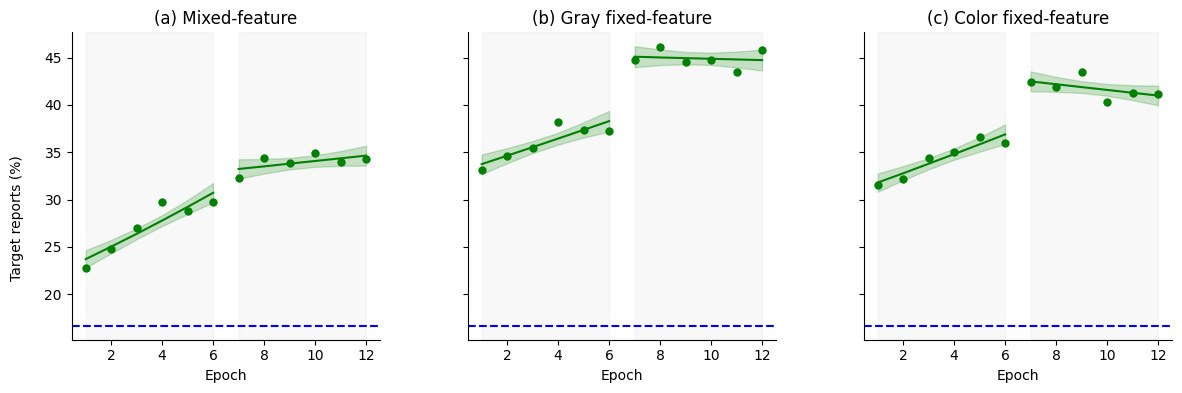

In [12]:
import seaborn as sns
import pandas as pd
import arviz as az
import bambi as bmb
from matplotlib.pylab import plt
from matplotlib.patches import Rectangle
from matplotlib import cycler
from brokenaxes import brokenaxes
from scikits import bootstrap
import numpy as np
import warnings
warnings.filterwarnings("ignore")


data = pd.read_csv('data/Dataset_TaskPerformance.csv', sep=';', decimal=',')
data['report frequency target'] = (data['correct'] / data['count'])*100

idata = az.from_netcdf('traces/TaskPerformance_trace.nc')


model = bmb.Model(
    '''p(correct, count) ~ 
       task*session*epoch + (1|participant) 
    ''',
    data, family='binomial', categorical=["session", "task", "participant"])


# Plot observed data
session_to_move = 2  
data_moved = data.copy()
data_moved.loc[data_moved['session'] == session_to_move, 'epoch'] += 6  

g = sns.FacetGrid(data_moved, col='task', height=4, col_order = ["color", "gray", "mixed"], )

performance_plot = g.map(sns.lineplot, 'epoch', 'report frequency target', 'session',
                         marker='o', linestyle='', err_style='band', errorbar=None, palette=['green', 'green'], markeredgecolor='none')


for ax in g.axes[0]:
    ax.set_xlabel("Epoch")
    ax.axvspan(1,6, color='gray', alpha=0.05)
    ax.axvspan(7,12, color='gray', alpha=0.05)


# change/remove labels
plt.figure(1).axes[0].get_yaxis().get_label().set(text='')

plt.figure(1).axes[0].set_title("(c) Color fixed-feature")
plt.figure(1).axes[0].set(position=[0.7, 0.1457, 0.257, 0.7685])
plt.figure(1).axes[0].tick_params(left = True, labelleft = False)
plt.figure(1).axes[0].axhline(y=16.66, color='b', linestyle='--')

plt.figure(1).axes[1].set_title("(b) Gray fixed-feature")
plt.figure(1).axes[1].set(position=[0.37, 0.1457, 0.257, 0.7685])
plt.figure(1).axes[1].axhline(y=16.66, color='b', linestyle='--')

plt.figure(1).axes[2].set_title("(a) Mixed-feature")
plt.figure(1).axes[2].tick_params(left = True, labelleft = True)
plt.figure(1).axes[2].set(position=[0.04, 0.1457, 0.257, 0.7685])
plt.figure(1).axes[2].text(-0.20, 0.2, 'Target reports (%)', transform=plt.figure(1).axes[2].transAxes, rotation=90.) 
plt.figure(1).axes[2].axhline(y=16.66, color='b', linestyle='--')

summary = estimates_df.groupby(['task', 'session']).mean().reset_index()

def plot_slopes_sessions(task, session, summary, ax, color):
    subset = estimates_df.query('task=="%s" and session==%d'%(task, session))
    y = subset['estimate']
    offset = ((session==2)*1)*6
    lower, upper = subset['lower_2.5%'], subset['upper_97.5%']
    ax.plot(range(1+offset,7+offset),y, '-', color=color)
    ax.fill_between(range(1+offset,7+offset), lower, upper, alpha=0.2, color=color)
    
    
plot_slopes_sessions('mixed', 1, summary, ax=plt.figure(1).axes[2], color="green")
plot_slopes_sessions('mixed', 2, summary, ax=plt.figure(1).axes[2], color="green")
plot_slopes_sessions('color', 1, summary, ax=plt.figure(1).axes[0], color="green")
plot_slopes_sessions('color', 2, summary, ax=plt.figure(1).axes[0], color="green")
plot_slopes_sessions('gray', 1, summary, ax=plt.figure(1).axes[1], color="green")
plot_slopes_sessions('gray', 2, summary, ax=plt.figure(1).axes[1], color="green")

_=plt.plot()

### 7) Compute slopes and comparisons

#### 7.1) Slopes across sessions

In [13]:
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import bambi as bmb
from bambi.interpret.helpers import data_grid, select_draws
import warnings
bmb.config["INTERPRET_VERBOSE"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

# Get data
data = pd.read_csv('data/Dataset_TaskPerformance.csv', sep=';', decimal=',')

# Define model
idata = az.from_netcdf('traces/TaskPerformance_trace.nc')

model = bmb.Model(
    '''p(correct, count) ~ 
       task*session*epoch + (1|participant) 
    ''',
    data, family='binomial', categorical=["session", "task", "participant"])


# Create data_grid
tasks = ["color", "gray", "mixed"]
sessions = [1, 2]
participants_mixed = np.arange(1, 19)
participants_gray = np.arange(19, 36)
participants_color = np.arange(36, 54 )

variables = {"epoch": np.arange(1, 7)}

data_dict = {}
idata_dict = {}

for task in tasks:
    if task == "mixed":
        participants = participants_mixed
    elif task == "gray":
        participants = participants_gray
    else:
        participants = participants_color
            
    conditional = {"participant": participants, "session": sessions, "task": np.array([task])}
    key = f"{task}_data"
    data_dict[key] = data_grid(model, conditional, variables)
    idata_dict[key] = model.predict(idata, data=data_dict[key], inplace=False)
        

results_list = []
hdi_list = []

def calculate_stats(idata_dict, data_dict, task):
    key = f"{task}_data" 
    draws_1 = select_draws(idata_dict[key], data_dict[key], {"epoch": 1}, "p(correct, count)_mean")
    draws_2 = select_draws(idata_dict[key], data_dict[key], {"epoch": 2}, "p(correct, count)_mean")
    draws_3 = select_draws(idata_dict[key], data_dict[key], {"epoch": 3}, "p(correct, count)_mean")
    draws_4 = select_draws(idata_dict[key], data_dict[key], {"epoch": 4}, "p(correct, count)_mean")
    draws_5 = select_draws(idata_dict[key], data_dict[key], {"epoch": 5}, "p(correct, count)_mean")
    draws_6 = select_draws(idata_dict[key], data_dict[key], {"epoch": 6}, "p(correct, count)_mean")
    
    diff_epoch_21 = (draws_2 - draws_1)    
    diff_epoch_32 = (draws_3 - draws_2)
    diff_epoch_43 = (draws_4 - draws_3)
    diff_epoch_54 = (draws_5 - draws_4)
    diff_epoch_65 = (draws_6 - draws_5)

        
    slopes_allSessions =xr.concat([xr.concat([diff_epoch_21,
               diff_epoch_32,
               diff_epoch_43,
               diff_epoch_54,
               diff_epoch_65],
              'Epoche')\
        .mean(dim='Epoche')],
        dim='Session'
    ).rename('Slopes')
      
    slopes = slopes_allSessions.mean(dim='p(correct, count)_obs').values
    results_list.append({"task": task, "slope": np.mean(slopes)})

    hdi_bothSessions = az.hdi(slopes_allSessions.mean(dim='p(correct, count)_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95) 
    hdi_df = hdi_bothSessions.to_dataframe(dim_order=None)
    hdi_list.append(hdi_df)
        
for task in tasks:
    calculate_stats(idata_dict, data_dict, task)

slopes_df = pd.DataFrame(results_list)

def extract_hdi_values(hdi_df):
    lower_value = hdi_df.loc[(0, 'lower'), 'Slopes']
    higher_value = hdi_df.loc[(0, 'higher'), 'Slopes']
    return lower_value, higher_value
  
for i, hdi_df in enumerate(hdi_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    slopes_df.at[i, 'lower_2.5%'] = lower_col
    slopes_df.at[i, 'upper_97.5%'] = higher_col
    

slopes_df[['slope', 'lower_2.5%', 'upper_97.5%']] *= 100
slopes_df = slopes_df.round({'slope': 2, 'lower_2.5%': 2, 'upper_97.5%': 2})
    
display(slopes_df)

,task,slope,lower_2.5%,upper_97.5%
0,color,0.36,0.12,0.60
1,gray,0.42,0.16,0.67
2,mixed,0.84,0.60,1.07


#### 7.2) Slopes within sessions

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import bambi as bmb
from bambi.interpret.helpers import data_grid, select_draws
import warnings
bmb.config["INTERPRET_VERBOSE"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

# Get data
data = pd.read_csv('data/Dataset_TaskPerformance.csv', sep=';', decimal=',')

# Define model
idata = az.from_netcdf('traces/TaskPerformance_trace.nc')


model = bmb.Model(
    '''p(correct, count) ~ 
       task*session*epoch + (1|participant) 
    ''',
    data, family='binomial', categorical=["session", "task", "participant"])


# Create data_grid
tasks = ["color", "gray", "mixed"]
sessions = [1, 2]
participants_mixed = np.arange(1, 19)
participants_gray = np.arange(19, 36)
participants_color = np.arange(36, 54 )

variables = {"epoch": np.arange(1, 7)}

data_dict = {}
idata_dict = {}

for task in tasks:
    if task == "mixed":
        participants = participants_mixed
    elif task == "gray":
        participants = participants_gray
    else:
        participants = participants_color
            
    conditional = {"participant": participants, "session": sessions, "task": np.array([task])}
    key = f"{task}_data"
    data_dict[key] = data_grid(model, conditional, variables)
    idata_dict[key] = model.predict(idata, data=data_dict[key], inplace=False)

    
# within tasks 
results_list = []
hdi_S1_list = []
hdi_S2_list = []
slopes_save = {}

def calculate_stats(idata_dict, data_dict, task):
    key = f"{task}_data" 
    draws_session1_1 = select_draws(idata_dict[key], data_dict[key], {"session": 1, "epoch": 1}, "p(correct, count)_mean")
    draws_session1_2 = select_draws(idata_dict[key], data_dict[key], {"session": 1, "epoch": 2}, "p(correct, count)_mean")
    draws_session1_3 = select_draws(idata_dict[key], data_dict[key], {"session": 1, "epoch": 3}, "p(correct, count)_mean")
    draws_session1_4 = select_draws(idata_dict[key], data_dict[key], {"session": 1, "epoch": 4}, "p(correct, count)_mean")
    draws_session1_5 = select_draws(idata_dict[key], data_dict[key], {"session": 1, "epoch": 5}, "p(correct, count)_mean")
    draws_session1_6 = select_draws(idata_dict[key], data_dict[key], {"session": 1, "epoch": 6}, "p(correct, count)_mean")
    
    draws_session2_1 = select_draws(idata_dict[key], data_dict[key], {"session": 2, "epoch": 1}, "p(correct, count)_mean")
    draws_session2_2 = select_draws(idata_dict[key], data_dict[key], {"session": 2, "epoch": 2}, "p(correct, count)_mean")
    draws_session2_3 = select_draws(idata_dict[key], data_dict[key], {"session": 2, "epoch": 3}, "p(correct, count)_mean")
    draws_session2_4 = select_draws(idata_dict[key], data_dict[key], {"session": 2, "epoch": 4}, "p(correct, count)_mean")
    draws_session2_5 = select_draws(idata_dict[key], data_dict[key], {"session": 2, "epoch": 5}, "p(correct, count)_mean")
    draws_session2_6 = select_draws(idata_dict[key], data_dict[key], {"session": 2, "epoch": 6}, "p(correct, count)_mean")

    diff_session1_epoch_21 = (draws_session1_2 - draws_session1_1)    
    diff_session1_epoch_32 = (draws_session1_3 - draws_session1_2)
    diff_session1_epoch_43 = (draws_session1_4 - draws_session1_3)
    diff_session1_epoch_54 = (draws_session1_5 - draws_session1_4)
    diff_session1_epoch_65 = (draws_session1_6 - draws_session1_5)

    diff_session2_epoch_21 = (draws_session2_2 - draws_session2_1)
    diff_session2_epoch_32 = (draws_session2_3 - draws_session2_2)
    diff_session2_epoch_43 = (draws_session2_4 - draws_session2_3)
    diff_session2_epoch_54 = (draws_session2_5 - draws_session2_4)
    diff_session2_epoch_65 = (draws_session2_6 - draws_session2_5)

        
    slopes =xr.concat([xr.concat([diff_session1_epoch_21,
               diff_session1_epoch_32,
               diff_session1_epoch_43,
               diff_session1_epoch_54,
               diff_session1_epoch_65],
              'Epoche')\
        .mean(dim='Epoche'),
        xr.concat([diff_session2_epoch_21,
               diff_session2_epoch_32,
               diff_session2_epoch_43,
               diff_session2_epoch_54,
               diff_session2_epoch_65],
              'Epoche')\
        .mean(dim='Epoche')],
        dim='Session'
    ).rename('Slopes')
    
    
    slopes_save[key] =xr.concat([xr.concat([diff_session1_epoch_21,
               diff_session1_epoch_32,
               diff_session1_epoch_43,
               diff_session1_epoch_54,
               diff_session1_epoch_65],
              'Epoche')\
        .mean(dim='Epoche'),
        xr.concat([diff_session2_epoch_21,
               diff_session2_epoch_32,
               diff_session2_epoch_43,
               diff_session2_epoch_54,
               diff_session2_epoch_65],
              'Epoche')\
        .mean(dim='Epoche')],
        dim='Session'
    ).rename('Slopes')
    

    # session 1
    slopes_1 = slopes.sel(Session=0).mean(dim='p(correct, count)_obs').values
    results_list.append({"session": 1, "task": task, "slope": np.mean(slopes_1)})
    hdi_S1 = az.hdi(slopes.sel(Session=0).mean(dim='p(correct, count)_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_S1_df = hdi_S1.to_dataframe(dim_order=None)
    hdi_S1_list.append(hdi_S1_df)
    
    # session 2
    slopes_2 = slopes.sel(Session=1).mean(dim='p(correct, count)_obs').values
    results_list.append({"session": 2, "task": task, "slope": np.mean(slopes_2)})
    hdi_S2 = az.hdi(slopes.sel(Session=1).mean(dim='p(correct, count)_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_S2_df = hdi_S2.to_dataframe(dim_order=None)
    hdi_S2_list.append(hdi_S2_df)


for task in tasks:
    calculate_stats(idata_dict, data_dict, task)

slopes_df = pd.DataFrame(results_list)
slopes_df = slopes_df.sort_values(by=['session', 'task']).reset_index(drop=True)

Session1_indices = slopes_df[slopes_df['session'] == 1].index
Session2_indices = slopes_df[slopes_df['session'] == 2].index

def extract_hdi_values(hdi_df):
    lower_value = hdi_df.loc['lower', 'Slopes']
    higher_value = hdi_df.loc['higher', 'Slopes']
    return lower_value, higher_value

for S1_index, hdi_df in zip(Session1_indices, hdi_S1_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    slopes_df.at[S1_index, 'lower_2.5%'] = lower_col
    slopes_df.at[S1_index, 'upper_97.5%'] = higher_col

for S2_index, hdi_df in zip(Session2_indices, hdi_S2_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    slopes_df.at[S2_index, 'lower_2.5%'] = lower_col
    slopes_df.at[S2_index, 'upper_97.5%'] = higher_col
    
slopes_df[['slope', 'lower_2.5%', 'upper_97.5%']] *= 100
slopes_df = slopes_df.round({'slope': 2, 'lower_2.5%': 2, 'upper_97.5%': 2})
    
display(slopes_df)


# Between-comparisons
between_comparisons_list = []
hdi_S1_diff_list = []
hdi_S2_diff_list = []

# Mixed-feature task vs color fixed-feature task
slopes_diff_mixed_color = slopes_save["mixed_data"] - slopes_save["color_data"]
diff_mixed_color_1 = slopes_diff_mixed_color.sel(Session=0).mean(dim='p(correct, count)_obs').values
between_comparisons_list.append({"session": 1, "task": "Δ (mixed, color)", "slope": np.mean(diff_mixed_color_1)})
hdi_S1_mixed_color = az.hdi(slopes_diff_mixed_color.sel(Session=0).mean(dim='p(correct, count)_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
hdi_S1_df_mixed_color = hdi_S1_mixed_color.to_dataframe(dim_order=None)
hdi_S1_diff_list.append(hdi_S1_df_mixed_color)

diff_mixed_color_2 = slopes_diff_mixed_color.sel(Session=1).mean(dim='p(correct, count)_obs').values
between_comparisons_list.append({"session": 2, "task": "Δ (mixed, color)", "slope": np.mean(diff_mixed_color_2)})
between_comparisons_df = pd.DataFrame(between_comparisons_list)
hdi_S2_mixed_color = az.hdi(slopes_diff_mixed_color.sel(Session=1).mean(dim='p(correct, count)_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
hdi_S2_df_mixed_color = hdi_S2_mixed_color.to_dataframe(dim_order=None)
hdi_S2_diff_list.append(hdi_S2_df_mixed_color)


# Mixed-feature task vs gray fixed-feature task
slopes_diff_mixed_gray = slopes_save["mixed_data"] - slopes_save["gray_data"]
diff_mixed_gray_1 = slopes_diff_mixed_gray.sel(Session=0).mean(dim='p(correct, count)_obs').values
between_comparisons_list.append({"session": 1, "task": "Δ (mixed, gray)", "slope": np.mean(diff_mixed_gray_1)})
hdi_S1_mixed_gray = az.hdi(slopes_diff_mixed_gray.sel(Session=0).mean(dim='p(correct, count)_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
hdi_S1_df_mixed_gray = hdi_S1_mixed_gray.to_dataframe(dim_order=None)
hdi_S1_diff_list.append(hdi_S1_df_mixed_gray)
  
diff_mixed_gray_2 = slopes_diff_mixed_gray.sel(Session=1).mean(dim='p(correct, count)_obs').values
between_comparisons_list.append({"session": 2, "task": "Δ (mixed, gray)", "slope": np.mean(diff_mixed_gray_2)})
between_comparisons_df = pd.DataFrame(between_comparisons_list)
hdi_S2_mixed_gray = az.hdi(slopes_diff_mixed_gray.sel(Session=1).mean(dim='p(correct, count)_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
hdi_S2_df_mixed_gray = hdi_S2_mixed_gray.to_dataframe(dim_order=None)
hdi_S2_diff_list.append(hdi_S2_df_mixed_gray)


# Gray fixed-feature task vs color fixed-feature task
slopes_diff_gray_color = slopes_save["gray_data"] - slopes_save["color_data"]
diff_gray_color_1 = slopes_diff_gray_color.sel(Session=0).mean(dim='p(correct, count)_obs').values
between_comparisons_list.append({"session": 1, "task": "Δ (gray, color)", "slope": np.mean(diff_gray_color_1)})
hdi_S1_gray_color = az.hdi(slopes_diff_gray_color.sel(Session=0).mean(dim='p(correct, count)_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
hdi_S1_df_gray_color = hdi_S1_gray_color.to_dataframe(dim_order=None)
hdi_S1_diff_list.append(hdi_S1_df_gray_color)

diff_gray_color_2 = slopes_diff_gray_color.sel(Session=1).mean(dim='p(correct, count)_obs').values
between_comparisons_list.append({"session": 2, "task": "Δ (gray, color)", "slope": np.mean(diff_gray_color_2)})
between_comparisons_df = pd.DataFrame(between_comparisons_list)
hdi_S2_gray_color = az.hdi(slopes_diff_gray_color.sel(Session=1).mean(dim='p(correct, count)_obs'), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
hdi_S2_df_gray_color = hdi_S2_gray_color.to_dataframe(dim_order=None)
hdi_S2_diff_list.append(hdi_S2_df_gray_color)

Session1_indices = between_comparisons_df[between_comparisons_df['session'] == 1].index
Session2_indices = between_comparisons_df[between_comparisons_df['session'] == 2].index

for S1_index, hdi_df in zip(Session1_indices, hdi_S1_diff_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    between_comparisons_df.at[S1_index, 'lower_2.5%'] = lower_col
    between_comparisons_df.at[S1_index, 'upper_97.5%'] = higher_col

for S2_index, hdi_df in zip(Session2_indices, hdi_S2_diff_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    between_comparisons_df.at[S2_index, 'lower_2.5%'] = lower_col
    between_comparisons_df.at[S2_index, 'upper_97.5%'] = higher_col

between_comparisons_df[['slope', 'lower_2.5%', 'upper_97.5%']] *= 100
between_comparisons_df = between_comparisons_df.round({'slope': 2, 'lower_2.5%': 2, 'upper_97.5%': 2})

display(between_comparisons_df)

,session,task,slope,lower_2.5%,upper_97.5%
0,1,color,1.02,0.69,1.35
1,1,gray,0.91,0.56,1.26
2,1,mixed,1.40,1.08,1.72
3,2,color,-0.30,-0.64,0.04
4,2,gray,-0.07,-0.43,0.29
5,2,mixed,0.28,-0.06,0.63


,session,task,slope,lower_2.5%,upper_97.5%
0,1,"Δ (mixed, color)",0.38,-0.07,0.83
1,2,"Δ (mixed, color)",0.58,0.11,1.06
2,1,"Δ (mixed, gray)",0.51,0.04,0.99
3,2,"Δ (mixed, gray)",0.36,-0.16,0.84
4,1,"Δ (gray, color)",-0.10,-0.58,0.37
5,2,"Δ (gray, color)",0.23,-0.26,0.72
